## Initiate Project

In [106]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

RSEED = 42

In [107]:
# Read data
df_tanzania=pd.read_csv("data/Train.csv")

In [108]:
# As our target is TZN money, function to have custom format to make the plots more readable. 
def thousands_formatter(x, pos):
    return f'{int(x):,}'

## Train-Test Split

In [109]:
# split train-test data. We have dropped:
# Decision to drop also all numerical features, as we do not see correlation, plus other features that don't seem to have an impact on the final cost

X = df_tanzania.drop(['total_cost','ID', "most_impressing", "country",'total_female','total_male','night_mainland', 'night_zanzibar','payment_mode','info_source','purpose','travel_with'],axis=1)
y = df_tanzania.total_cost

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=RSEED)
# Build new data frame for EDA

df_tanzania_train = X_train.join(y_train)
df_tanzania_test = X_test.join(y_test)

## Evaluate Target 

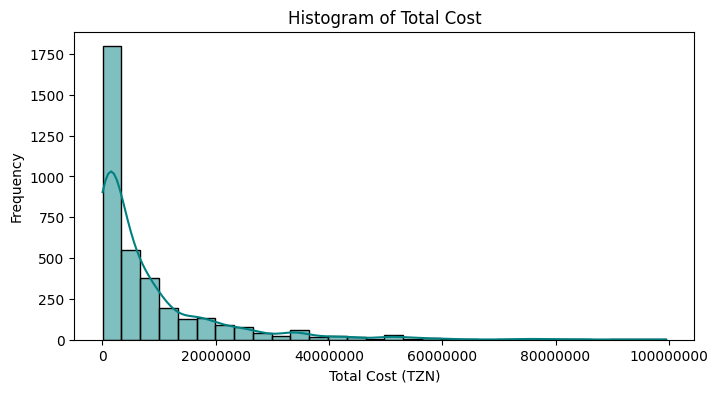

In [110]:
# Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df_tanzania_train["total_cost"], bins=30, kde=True, color='teal')
plt.title('Histogram of Total Cost')
plt.xlabel('Total Cost (TZN)')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain')
plt.show()

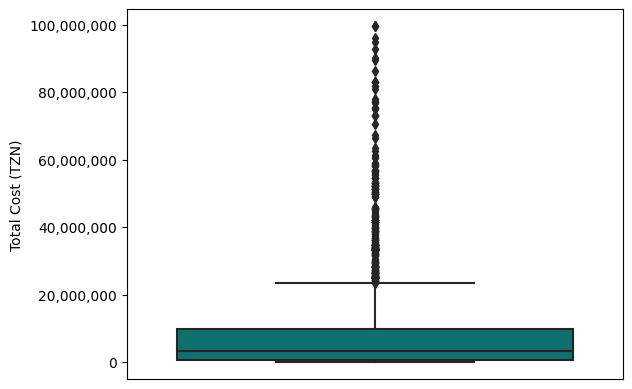

In [111]:
# Plotting the boxplot
sns.boxplot(df_tanzania_train["total_cost"], color="teal")
plt.xticks([])  # Removes the x-axis ticks

# Adding the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Adding label
plt.ylabel("Total Cost (TZN)")

# Display the plot
plt.show()

In [112]:
# Define function to print the whiskers of a boxplot

def calculate_whiskers(df, column):
    """
    Calculate the lower and upper whiskers for a specified column in a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        column (str): The column name to calculate whiskers for.

    Returns:
        tuple: (lower_whisker, upper_whisker)
    """
    # Get descriptive statistics for the column
    stats = df[column].describe()
    Q1 = stats['25%']
    Q3 = stats['75%']
    IQR = Q3 - Q1

    # Calculate the lower whisker
    lower_whisker = max(
        df[column][df[column] >= (Q1 - 1.5 * IQR)].min(), 
        df[column].min()
    )
    
    # Calculate the upper whisker
    upper_whisker = min(
        df[column][df[column] <= (Q3 + 1.5 * IQR)].max(), 
        df[column].max()
    )
    
    return lower_whisker, upper_whisker

In [113]:
lower, upper = calculate_whiskers(df_tanzania_train, "total_cost")
print("Upper Whisker total cost", upper)

Upper Whisker total cost 23601032.0


In [114]:
#Remove outliers
df_tanzania_train = df_tanzania_train.query("total_cost <= 23601032.0")

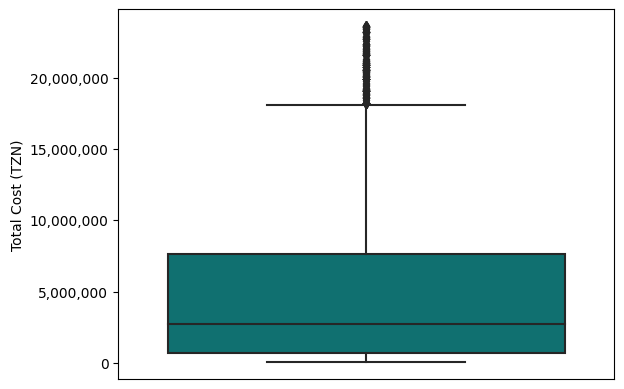

In [115]:
# Plotting the boxplot
sns.boxplot(df_tanzania_train["total_cost"], color="teal")
plt.xticks([])  # Removes the x-axis ticks

# Adding the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Adding label
plt.ylabel("Total Cost (TZN)")

# Display the plot
plt.show()

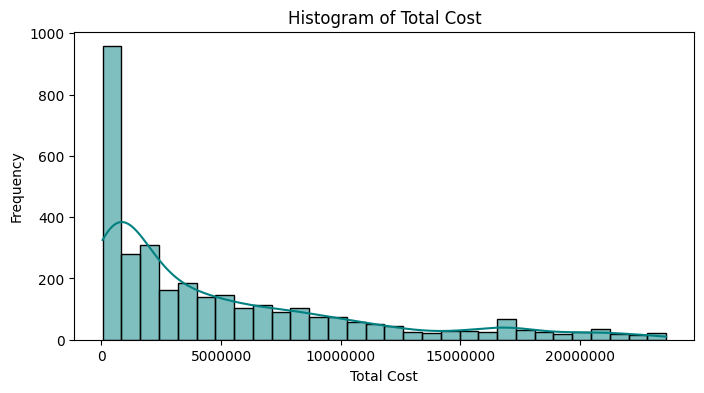

In [116]:
# Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df_tanzania_train["total_cost"], bins=30, kde=True, color='teal')
plt.title('Histogram of Total Cost')
plt.xlabel('Total Cost')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain')
plt.show()

## EDA

In [117]:
df_tanzania_train.columns

Index(['age_group', 'main_activity', 'tour_arrangement',
       'package_transport_int', 'package_accomodation', 'package_food',
       'package_transport_tz', 'package_sightseeing', 'package_guided_tour',
       'package_insurance', 'first_trip_tz', 'total_cost'],
      dtype='object')

In [118]:
# Check for empty values. We have them in "total_female", "total_male" and mostly in "travel_with"

df_tanzania_train.isnull().sum()

age_group                0
main_activity            0
tour_arrangement         0
package_transport_int    0
package_accomodation     0
package_food             0
package_transport_tz     0
package_sightseeing      0
package_guided_tour      0
package_insurance        0
first_trip_tz            0
total_cost               0
dtype: int64

In [119]:
# most of our features are categorical, besides four of them: 
# total_female, total_male, night_mainland, night_zanzibar and the total cost

df_tanzania_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3284 entries, 3075 to 860
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age_group              3284 non-null   object 
 1   main_activity          3284 non-null   object 
 2   tour_arrangement       3284 non-null   object 
 3   package_transport_int  3284 non-null   object 
 4   package_accomodation   3284 non-null   object 
 5   package_food           3284 non-null   object 
 6   package_transport_tz   3284 non-null   object 
 7   package_sightseeing    3284 non-null   object 
 8   package_guided_tour    3284 non-null   object 
 9   package_insurance      3284 non-null   object 
 10  first_trip_tz          3284 non-null   object 
 11  total_cost             3284 non-null   float64
dtypes: float64(1), object(11)
memory usage: 462.6+ KB


## Some Plots

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Wildlife tourism'),
  Text(1, 0, 'Beach tourism'),
  Text(2, 0, 'Hunting tourism'),
  Text(3, 0, 'Mountain climbing'),
  Text(4, 0, 'Cultural tourism'),
  Text(5, 0, 'Conference tourism'),
  Text(6, 0, 'Bird watching'),
  Text(7, 0, 'business'),
  Text(8, 0, 'Diving and Sport Fishing')])

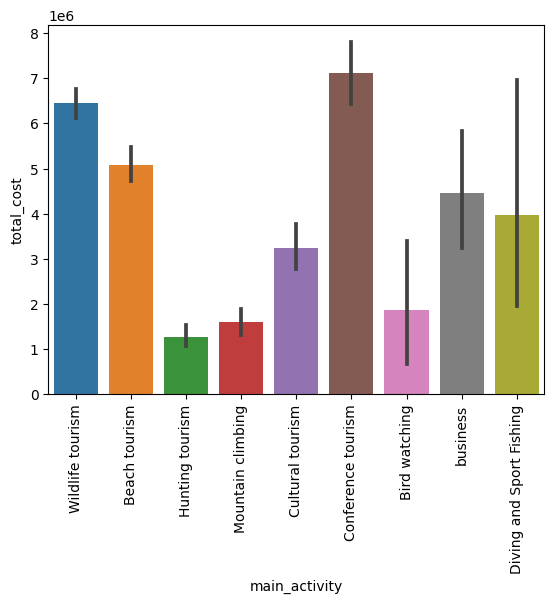

In [120]:
sns.barplot(df_tanzania_train, x="main_activity", y="total_cost")
plt.xticks(rotation=90)

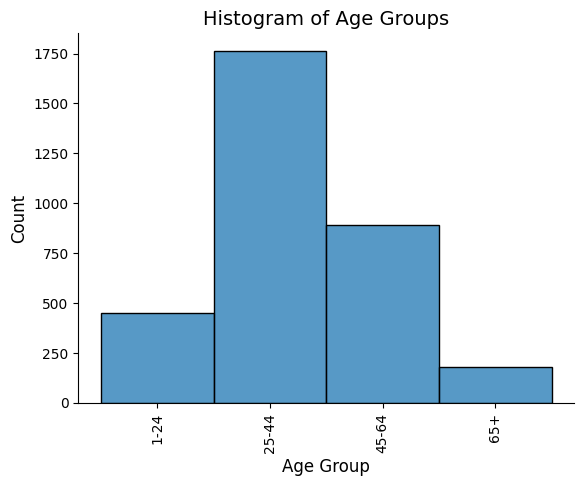

In [121]:
# <Reorganize the age_group and make it categorical

custom_order = ['1-24', '25-44', '45-64', "65+"] 


# Convert 'age_group' into a categorical variable with the custom order
df_tanzania_train['age_group'] = pd.Categorical(
    df_tanzania_train['age_group'], 
    categories=custom_order, 
    ordered=True
)

# Plot the histogram
sns.histplot(data=df_tanzania_train, x='age_group', stat='count', palette="viridis")

# Aesthetics
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Histogram of Age Groups", fontsize=14)
plt.xticks(rotation=90)
sns.despine()


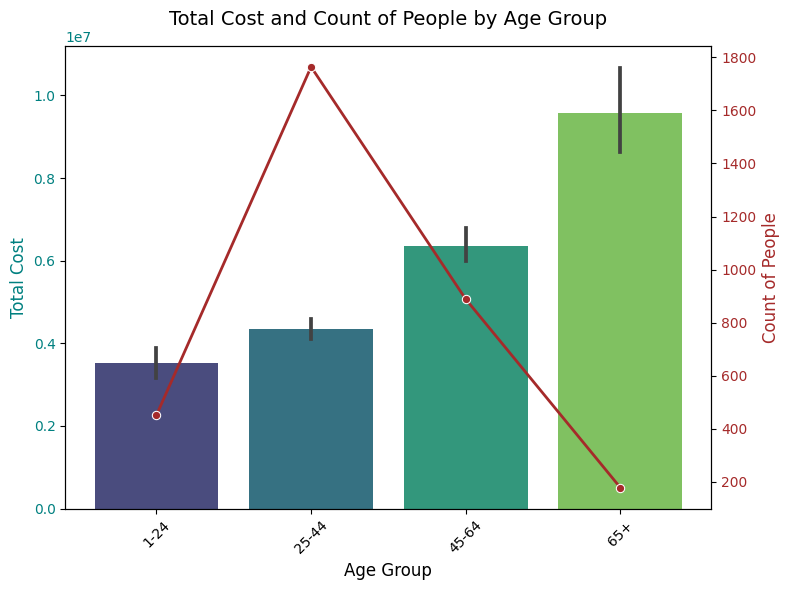

In [122]:
# Group by age_group to calculate total cost and counts
grouped = df_tanzania_train.groupby('age_group').agg(
    total_cost=('total_cost', 'sum'),
    count=('total_cost', 'count')
).reindex(['1-24', '25-44', '45-64', "65+"])  # Ensure custom order

# Create the figure and first y-axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the bar chart for total cost
sns.barplot(x=df_tanzania_train.age_group, y=df_tanzania_train.total_cost, ax=ax1, palette="viridis")
ax1.set_ylabel("Total Cost", fontsize=12, color="teal")
ax1.set_xlabel("Age Group", fontsize=12)
ax1.tick_params(axis='y', labelcolor="teal")
ax1.tick_params(axis='x', rotation=45)
ax1.set_title("Total Cost and Count of People by Age Group", fontsize=14, pad=15)

# Create the second y-axis
ax2 = ax1.twinx()

# Plot the line chart for the count of people
sns.lineplot(x=grouped.index, y=grouped['count'], ax=ax2, color="brown", marker="o", linewidth=2)
ax2.set_ylabel("Count of People", fontsize=12, color="brown")
ax2.tick_params(axis='y', labelcolor="brown")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Feature Engineering - Train

### Encoding

In [123]:
#List of columns
col_encode = ['age_group', 'main_activity', 'tour_arrangement']
col_map = ['package_transport_int', 'package_accomodation', 'package_food','package_transport_tz', 'package_sightseeing', 'package_guided_tour','package_insurance','first_trip_tz',]

In [124]:
# Mapp all Yes/No features (col_map)

def mapping_tanzania(df,cols):
    df[cols] = df[cols].replace({'Yes': 1, 'No': 0}) 

mapping_tanzania(df_tanzania_train,col_map)

In [125]:
# Encode all categorical features (col_encode)
categories = [df_tanzania_train[col].unique() for col in col_encode]

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore', categories=categories)
ohe.fit(df_tanzania_train[col_encode]) 
t = ohe.transform(df_tanzania_train[col_encode])

# Purpose: It generates the new feature names created during one-hot encoding, reflecting the original categorical feature and its unique values.
ohe.get_feature_names_out() 
df_tanzania_train_encode = pd.DataFrame(t, columns= ohe.get_feature_names_out())

# introduced into the frame
df_tanzania_train = pd.concat([df_tanzania_train.reset_index(drop=True), df_tanzania_train_encode], axis=1)
df_tanzania_train.drop(columns=col_encode,inplace=True)

In [126]:
df_tanzania_train.shape

(3284, 21)

### Encoding - Pipeline / ColumnTransformer (WiP)

In [127]:
# # Custom transformer for `travel_with`
# class TravelWithTransformer(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         # Apply the logic for `travel_with` as described
#         X = X.copy()
#         for index, row in X.iterrows():
#             if pd.isnull(row['travel_with']):
#                 male = row['total_male']
#                 female = row['total_female']
#                 if male == 1 and female == 0:
#                     X.at[index, 'travel_with'] = 'Alone'
#                 elif male == 0 and female == 1:
#                     X.at[index, 'travel_with'] = 'Alone'
#                 else:
#                     X.at[index, 'travel_with'] = 'Unknown'
#         return X[['travel_with']]

#     def get_feature_names_out(self, input_features=None):
#         # Return the output column name for `travel_with`
#         return ['travel_with']

In [128]:
# # Custom imputer transformer to round the mean
# class RoundedMeanImputer(TransformerMixin, BaseEstimator):
#     def fit(self, X, y=None):
#         self.means_ = X.mean().round()
#         return self

#     def transform(self, X):
#         return X.fillna(self.means_)
    
#     def get_feature_names_out(self, input_features=None):
#         # Return the same feature names as the input
#         return input_features

In [129]:
# # ColumnTransformer with RoundedMeanImputer
# preprocessor = ColumnTransformer(
#     transformers=[
#         # Custom imputer for total_female and total_male using rounded mean
#         ('impute_num', RoundedMeanImputer(), ['total_female', 'total_male']),
        
#         # Map Yes/No features to 1/0 directly
#         ('map_binary', OneHotEncoder(drop='if_binary', sparse=False), col_map),

#         # Custom transformer for travel_with
#         ('custom_travel_with', TravelWithTransformer(), ['travel_with', 'total_male', 'total_female']),
        
#         # One-hot encode categorical features
#         ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), col_encode),
        
#         # Scale numerical features
#         ('scale', MinMaxScaler(), col_scale)
#     ],
#     remainder='passthrough'  # Keeps any columns not explicitly listed
# )

# # Full pipeline
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor)
# ])


In [130]:
# # Fit and transform the data
# df_processed = pipeline.fit_transform(df_tanzania_train)

# # Convert to DataFrame
# output_columns = pipeline.named_steps['preprocessor'].get_feature_names_out()
# df_processed = pd.DataFrame(df_processed, columns=output_columns)

# # Verify results
# print("Shape of processed DataFrame:", df_processed.shape)
# print("Remaining NaN values:", df_processed.isna().sum().sum())

## Feature Engineering - Test

In [131]:
df_tanzania_test = X_test.join(y_test)

### Encoding

In [132]:
mapping_tanzania(df_tanzania_test,col_map)

In [133]:
# Encode all categorical features (col_encode)

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore', categories=categories)
ohe.fit(df_tanzania_test[col_encode]) 
t = ohe.transform(df_tanzania_test[col_encode])

# Purpose: It generates the new feature names created during one-hot encoding, reflecting the original categorical feature and its unique values.
ohe.get_feature_names_out() 
df_tanzania_test_encode = pd.DataFrame(t, columns= ohe.get_feature_names_out())

# introduced into the frame
df_tanzania_test = pd.concat([df_tanzania_test.reset_index(drop=True), df_tanzania_test_encode], axis=1)
df_tanzania_test.drop(columns=col_encode,inplace=True)

In [134]:
# # Create a scaler for total_cost
# scaler_cost = MinMaxScaler()

# # Fit and transform the total_cost column
# scaled_values = scaler_cost.fit_transform(df_tanzania_test[["total_cost"]])

# # Replace the original total_cost column in the DataFrame with the scaled values
# df_tanzania_test["total_cost"] = scaled_values

In [135]:
df_tanzania_train.shape

(3284, 21)

In [136]:
df_tanzania_test.shape

(1203, 21)

# Modeling

In [137]:
X_train = df_tanzania_train.drop("total_cost", axis=1)
y_train = df_tanzania_train["total_cost"]
X_test = df_tanzania_test.drop("total_cost", axis=1)
y_test = df_tanzania_test["total_cost"]

In [138]:
# Define a function to calculate metrics

def evaluate_model(title, model, X_test, y_test):
    """
    Evaluate a model on the test set and print the evaluation metrics.

    Parameters:
        model_name (str): The name of the model to display in the title.
        model: The trained model to evaluate.
        X_test: Test features.
        y_test: True labels for the test set.
    """
    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print metrics with a title
    print(f"{title} {model}:")
    print(f" - Mean Squared Error (MSE): {mse}")
    print(f" - Root Mean Squared Error (RMSE): {rmse}")
    print(f" - Mean Absolute Error (MAE): {mae}")
    print(f" - R-squared (R²): {r2}\n")

In [139]:
# Define a function to plot actual vs predicted cost
def plot_model_results(model_name, model, y_train, y_pred):
    plt.figure(figsize=(7, 5))
    plt.scatter(y_train, y_pred, color='teal', alpha=0.5)
    plt.plot([0, df_tanzania_train["total_cost"].max()], [0, df_tanzania_train["total_cost"].max()], color='brown', linestyle='--')  # line of perfect predictions (45-degree line)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    plt.xlabel('Actual Values (Cost in TZN)')
    plt.ylabel('Actual Values (Cost in TZN)')
    plt.title(f'Predicted vs Actual Values: {model_name}')
    plt.show()

## Model: Decision Tree

In [140]:
# # Initialize baseline model Regressor
model_dt= DecisionTreeRegressor(max_features=2, random_state=RSEED)
model_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_features=2, random_state=42)

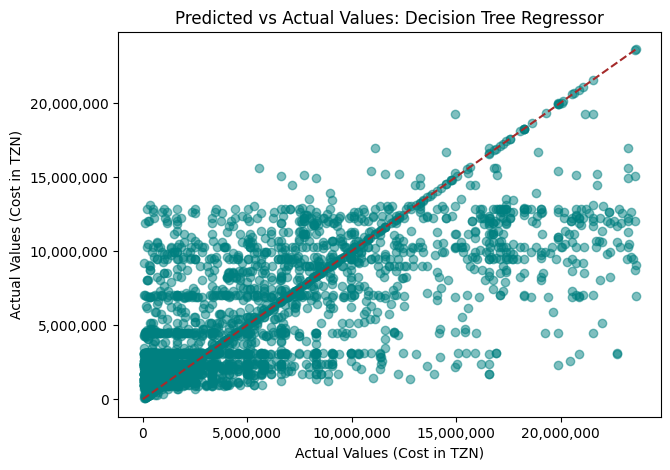

In [141]:
y_pred = model_dt.predict(X_train)
plot_model_results("Decision Tree Regressor", model_dt, y_train, y_pred)

In [142]:
evaluate_model("Train",model_dt, X_train, y_train)
evaluate_model("Test",model_dt, X_test, y_test)

Train DecisionTreeRegressor(max_features=2, random_state=42):
 - Mean Squared Error (MSE): 15377738992041.545
 - Root Mean Squared Error (RMSE): 3921446.033294548
 - Mean Absolute Error (MAE): 2600353.0756253474
 - R-squared (R²): 0.5262702661922958

Test DecisionTreeRegressor(max_features=2, random_state=42):
 - Mean Squared Error (MSE): 118944585821070.16
 - Root Mean Squared Error (RMSE): 10906171.914153479
 - Mean Absolute Error (MAE): 5676672.361469946
 - R-squared (R²): 0.17813894569763888



## Model: Linear Models (Linear, Lasso, Ridge)

In [143]:
# # Initialize baseline model Regressor
model_lr= LinearRegression()
model_lr.fit(X_train, y_train)

model_lasso= Lasso()
model_lasso.fit(X_train, y_train)

model_ridge= Ridge()
model_ridge.fit(X_train, y_train)

Ridge()

In [144]:
#evaluate Linear
evaluate_model("Train", model_lr, X_train, y_train)
evaluate_model("Test", model_lr, X_test, y_test)

Train LinearRegression():
 - Mean Squared Error (MSE): 19990206982919.047
 - Root Mean Squared Error (RMSE): 4471040.928343091
 - Mean Absolute Error (MAE): 3214837.8206724776
 - R-squared (R²): 0.38417764551211697

Test LinearRegression():
 - Mean Squared Error (MSE): 117685711135323.44
 - Root Mean Squared Error (RMSE): 10848304.528142793
 - Mean Absolute Error (MAE): 5582666.951976875
 - R-squared (R²): 0.18683728256871546



In [145]:
#evaluate Lasso
evaluate_model("Train", model_lasso, X_train, y_train)
evaluate_model("Test", model_lasso, X_test, y_test)

Train Lasso():
 - Mean Squared Error (MSE): 19990206984080.355
 - Root Mean Squared Error (RMSE): 4471040.92847296
 - Mean Absolute Error (MAE): 3214837.4204417327
 - R-squared (R²): 0.38417764547634137

Test Lasso():
 - Mean Squared Error (MSE): 117685719456817.42
 - Root Mean Squared Error (RMSE): 10848304.911681706
 - Mean Absolute Error (MAE): 5582664.508081312
 - R-squared (R²): 0.18683722507041256



In [146]:
#evaluate Ridge
evaluate_model("Train", model_ridge, X_train, y_train)
evaluate_model("Test", model_ridge, X_test, y_test)

Train Ridge():
 - Mean Squared Error (MSE): 19990485125708.83
 - Root Mean Squared Error (RMSE): 4471072.033160373
 - Mean Absolute Error (MAE): 3214536.584224737
 - R-squared (R²): 0.38416907698914804

Test Ridge():
 - Mean Squared Error (MSE): 117697631159867.92
 - Root Mean Squared Error (RMSE): 10848853.909969842
 - Mean Absolute Error (MAE): 5581723.472681661
 - R-squared (R²): 0.18675491981237968



## Model: Random Forest

In [147]:
model_rf= RandomForestRegressor(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

model_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestRegressor(max_features='sqrt', n_jobs=-1, random_state=42,
                      verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


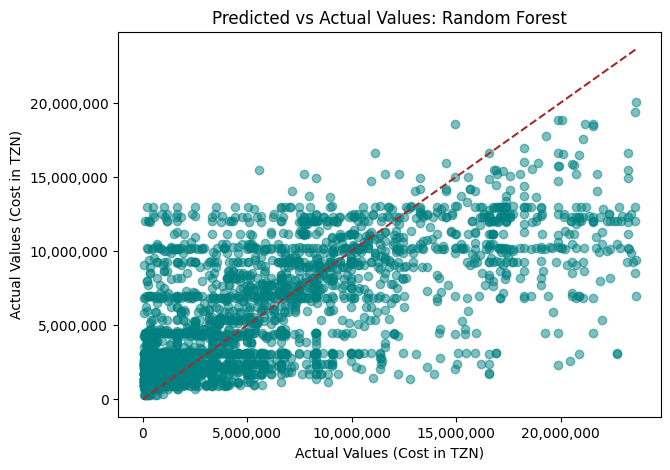

In [148]:
y_pred = model_rf.predict(X_train)
plot_model_results("Random Forest", model_rf, y_train, y_pred)


In [104]:
#evaluate Random Forest
evaluate_model("Train", model_rf, X_train, y_train)
evaluate_model("Test", model_rf, X_test, y_test)

Train RandomForestRegressor(max_features='sqrt', n_jobs=-1, random_state=42,
                      verbose=1):
 - Mean Squared Error (MSE): 15764902602506.588
 - Root Mean Squared Error (RMSE): 3970504.0741077936
 - Mean Absolute Error (MAE): 2741397.4256782453
 - R-squared (R²): 0.51434322579835

Test RandomForestRegressor(max_features='sqrt', n_jobs=-1, random_state=42,
                      verbose=1):
 - Mean Squared Error (MSE): 116814967395966.47
 - Root Mean Squared Error (RMSE): 10808097.306925325
 - Mean Absolute Error (MAE): 5553628.850622881
 - R-squared (R²): 0.19285378481398474



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


## Grid Search Optimisation

In [105]:
param_grid = [
    { 
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 15, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        "max_features":['sqrt', "log2", 2, 3, 5, 8, 10]
    }]


In [151]:

gs = GridSearchCV( 
    estimator=RandomForestRegressor(),
    param_grid= param_grid,
    cv=5,
    verbose=3, 
    error_score='raise',
    n_jobs=-1
)

#fit the model
gs.fit(X_train, y_train)

# Best score
print('Best score:', round(gs.best_score_, 3))

# Best parameters
print('Best parameters:', gs.best_params_)

Fitting 5 folds for each of 945 candidates, totalling 4725 fits
Best score: 0.387
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}


In [152]:
model_rf_1_opt = gs.best_estimator_

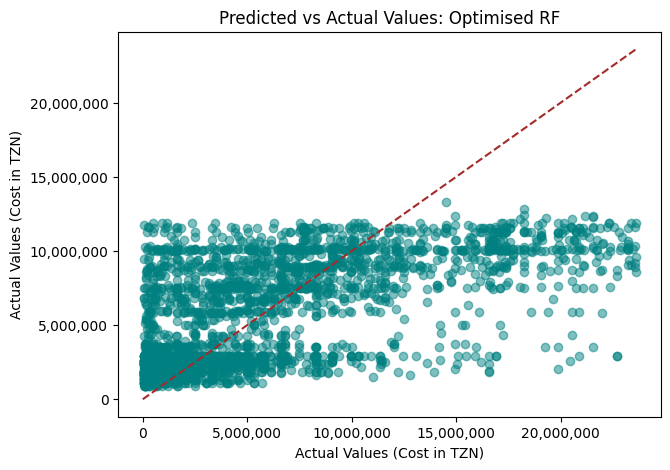

In [153]:
y_pred = model_rf_1_opt.predict(X_train)
plot_model_results("Optimised RF", model_rf_1_opt,y_train,y_pred)

In [154]:
evaluate_model("Train",model_rf_1_opt, X_train, y_train)
evaluate_model("Test",model_rf_1_opt, X_test, y_test)

Train RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=50):
 - Mean Squared Error (MSE): 18309080548744.89
 - Root Mean Squared Error (RMSE): 4278911.140552569
 - Mean Absolute Error (MAE): 3037372.091209867
 - R-squared (R²): 0.43596676604346296

Test RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=50):
 - Mean Squared Error (MSE): 116994888076827.83
 - Root Mean Squared Error (RMSE): 10816417.525078617
 - Mean Absolute Error (MAE): 5499385.295962262
 - R-squared (R²): 0.1916106025418135

